Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Benchmark TensorRT models inference

This tutorial shows how to convert a bundle in the MONAI model zoo to a TensorRT engine based script for better performance and benchmark the difference between the pytorch module and the TensorRT engine script.  
The spleen ct segmentation bundle is used as the example in this tutorial.The inference latency before and after the covert process will be compared. Feel free to modify the spleen ct segmentation bundle to any other bundles in the MONAI model zoo which support TensorRT convert. The supported bundle names are listed below. Please modify the net_id and input_shape in the tutorial to fit different bundles.

```
spleen_ct_segmentation
endoscopic_tool_segmentation
pathology_tumor_detection
```

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import glob
import os
import shutil
import tempfile
import time

import torch
import numpy as np
from typing import Union, Sequence, Tuple
from ignite.engine import Engine

import matplotlib.pyplot as plt
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import get_torch_version_tuple, set_determinism
from torch.jit._script import ScriptModule
from ignite.engine import Events
from collections import OrderedDict
from monai.engines import IterationEvents

print_config()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1+560.g6784821d
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6784821dedf89ce80590e022bad9fa536d242834
MONAI __file__: /home/liubin/data/github_monai/export_trt_build/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.6.4
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Download the spleen bundle

In [5]:
bundle_dir = "./"
bundle_path = os.path.join(bundle_dir, "spleen_ct_segmentation")
if not os.path.exists(bundle_path):
    monai.bundle.download(name="spleen_ct_segmentation", bundle_dir="./")

## Set MSD Spleen dataset path

In [6]:
train_images = sorted(glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Export the trt model with API

Export the downloaded bundle model to a TensorRT engine base torch script model. This may take a while for converting and will generate `model_trt_fp32.ts` and `model_trt_fp16.ts` to the `model` folder.

In [7]:
%cd spleen_ct_segmentation
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp32.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp32
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp16.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp16
%cd ..

/home/liubin/data/github_tutorial/1201-add-trt-benchmark-tutorial/tutorials/acceleration/spleen_ct_segmentation
2023-03-20 03:41:27,727 - INFO - --- input summary of monai.bundle.scripts.trt_export ---
2023-03-20 03:41:27,727 - INFO - > net_id: 'network_def'
2023-03-20 03:41:27,727 - INFO - > filepath: 'models/model_trt_fp32.ts'
2023-03-20 03:41:27,727 - INFO - > meta_file: 'configs/metadata.json'
2023-03-20 03:41:27,727 - INFO - > config_file: 'configs/inference.json'
2023-03-20 03:41:27,727 - INFO - > ckpt_file: 'models/model.pt'
2023-03-20 03:41:27,727 - INFO - > precision: 'fp32'
2023-03-20 03:41:27,727 - INFO - ---


There is no dynamic batch range. The converted model only takes [1, 1, 96, 96, 96] shape input.
2023-03-20 03:43:37,827 - INFO - exported to file: models/model_trt_fp32.ts.
2023-03-20 03:43:41,575 - INFO - --- input summary of monai.bundle.scripts.trt_export ---
2023-03-20 03:43:41,575 - INFO - > net_id: 'network_def'
2023-03-20 03:43:41,575 - INFO - > filepath: 'mode

## Load the torch model and TensorRT model

In [8]:
def get_parser(meta_config, inference_config):
    parser = monai.bundle.ConfigParser()
    parser.read_meta(meta_config)
    parser.read_config(inference_config)
    return parser

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weight = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "model.pt"))[0]
meta_config = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "metadata.*"))[0]
inference_config = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "inference.*"))[0]
trt_fp32_model_path = os.path.join("./spleen_ct_segmentation", "models", "model_trt_fp32.ts")
trt_fp16_model_path = os.path.join("./spleen_ct_segmentation", "models", "model_trt_fp16.ts")

parser = get_parser(meta_config, inference_config)

# If using other bundles, the net_id and spatial_shape may change. Please modify these variables accordingly.
net_id = "network"
spatial_shape = (1, 1, 96, 96, 96)
model = parser.get_parsed_content(net_id)

model = parser.get_parsed_content(net_id)
model.eval()
model.to(device)

trt_fp32_model = torch.jit.load(trt_fp32_model_path)
trt_fp16_model = torch.jit.load(trt_fp16_model_path)

## Benchmark the model inference time

In this part, we only benchmark the model inference with a random input.

Total time for the torch model: 2525.270125389099ms. Average time for the torch model: 5.050540250778188ms.


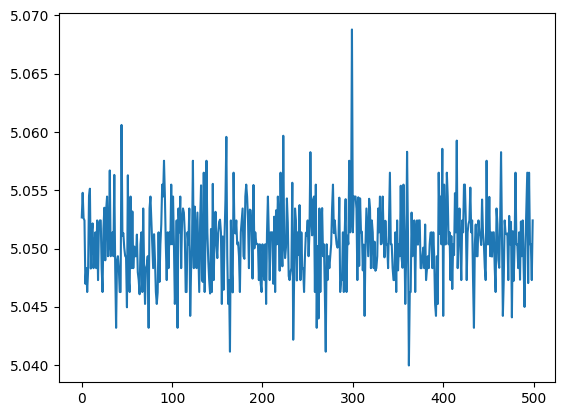

Total time for the TensorRT_fp32 model: 950.1194922924042ms. Average time for the TensorRT_fp32 model: 1.9002389845848044ms.


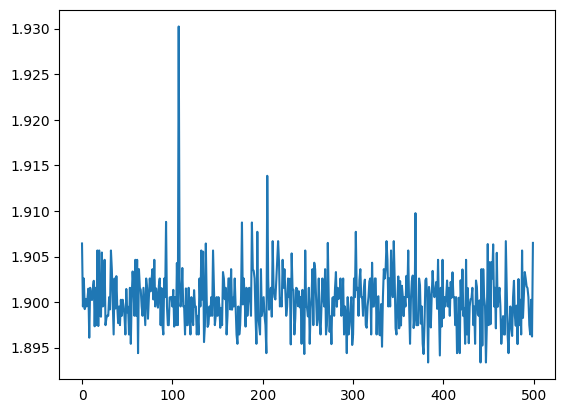

Total time for the TensorRT_fp16 model: 625.6335978507996ms. Average time for the TensorRT_fp16 model: 1.2512671957015966ms.


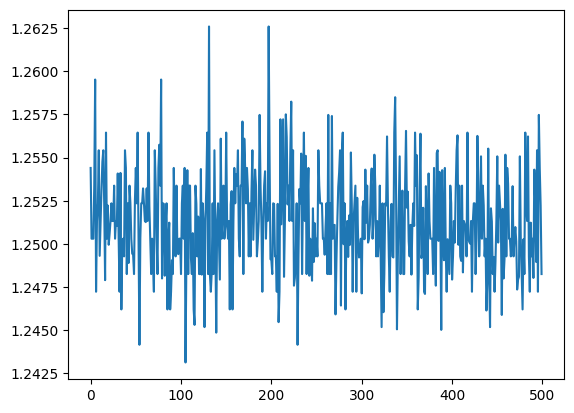

1.2512671957015966

In [9]:
def inference_random_torch_timer(model, input_shape, model_type="torch", warmup_iter=500, active_iter=500):

    is_torch_module = not isinstance(model, ScriptModule)
    with torch.no_grad():
        for _ in range(warmup_iter):
            random_input = torch.rand(input_shape, dtype=torch.float32, device=device)
            pred = model(random_input)

        timeaccumulate = []
        for _ in range(active_iter):
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            torch.cuda.synchronize()
            starter.record()
            pred = model(random_input)
            ender.record()
            torch.cuda.synchronize()
            time_cur = starter.elapsed_time(ender)
            timeaccumulate.append(time_cur)
        total_time = sum(timeaccumulate)
        average_time = total_time / (len(timeaccumulate) + 1e-12)
    print(
        f"Total time for the {model_type} model: {total_time}ms. Average time for the {model_type} model: {average_time}ms."
    )
    plt.plot(timeaccumulate)
    plt.show(model_type)
    return average_time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Only test the fp32 precision torch model
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

inference_random_torch_timer(model, spatial_shape, model_type="torch")
inference_random_torch_timer(trt_fp32_model, spatial_shape, model_type="TensorRT_fp32")
inference_random_torch_timer(trt_fp16_model, spatial_shape, model_type="TensorRT_fp16")

## Benchmark the end to end bundle run

In this part, the `evaluator` in the `spleen_ct_segmentation` is parsed to do the end to end inference. A `TimerHandler` is defined to benchmark every part of the inference process.

### Define the TimerHandler

Define a `CUDATimer` to time the latency on GPU and a `TimerHandler` to attach this timer to every part of end2end inference.

In [10]:
class CUDATimer:
    def __init__(self, type_str) -> None:
        self.time_list = []
        self.type_str = type_str
    
    def start(self) -> None:
        self.starter = torch.cuda.Event(enable_timing=True)
        self.ender = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        self.starter.record()
        
    def end(self) -> None:
        self.ender.record()
        torch.cuda.synchronize()
        self.time_list.append(self.starter.elapsed_time(self.ender))
    
    def get_max(self) -> float:
        return max(self.time_list)
    
    def get_min(self) -> float:
        return min(self.time_list)
    
    def get_mean(self) -> float:
        np_time = np.array(self.time_list)
        return np.mean(np_time)
    
    def get_std(self) -> float:
        np_time = np.array(self.time_list)
        return np.std(np_time)
    
    def get_sum(self) -> float:
        np_time = np.array(self.time_list)
        return np.sum(np_time)
    
    def get_results_dict(self) -> OrderedDict:
        out_list = [
            ("total", self.get_sum()),
            ("min", self.get_min()),
            ("max", self.get_max()),
            ("mean", self.get_mean()),
            ("std", self.get_std())
        ]
        return OrderedDict(out_list)
        

class TimerHandler:
    def __init__(self) -> None:
        self.run_timer = CUDATimer("RUN")
        self.epoch_timer = CUDATimer("EPOCH")
        self.iteration_timer = CUDATimer("ITERATION")
        self.net_forward_timer = CUDATimer("FORWARD")
        self.get_batch_timer = CUDATimer("PREPARE_BATCH")
        self.post_process_timer = CUDATimer("POST_PROCESS")
        self.timer_list = [self.run_timer, self.epoch_timer, self.iteration_timer, self.net_forward_timer,\
                          self.get_batch_timer, self.post_process_timer]
    

    def attach(self, engine: Engine) -> None:
        engine.add_event_handler(Events.STARTED, self.started, timer = self.run_timer)
        engine.add_event_handler(Events.EPOCH_STARTED, self.started, timer = self.epoch_timer)
        engine.add_event_handler(Events.ITERATION_STARTED, self.started, timer = self.iteration_timer)
        engine.add_event_handler(Events.GET_BATCH_STARTED, self.started, timer = self.get_batch_timer)
        engine.add_event_handler(Events.GET_BATCH_COMPLETED, self.completed, timer = self.get_batch_timer)
        engine.add_event_handler(Events.GET_BATCH_COMPLETED, self.started, timer = self.net_forward_timer)
        engine.add_event_handler(IterationEvents.FORWARD_COMPLETED, self.completed, timer = self.net_forward_timer)
        engine.add_event_handler(IterationEvents.FORWARD_COMPLETED, self.started, timer = self.post_process_timer)
        engine.add_event_handler(Events.ITERATION_COMPLETED, self.completed, timer = self.post_process_timer)
        engine.add_event_handler(Events.ITERATION_COMPLETED, self.completed, timer = self.iteration_timer)
        engine.add_event_handler(Events.EPOCH_COMPLETED, self.completed, timer = self.epoch_timer)
        engine.add_event_handler(Events.COMPLETED, self.completed, timer = self.run_timer)

    def started(self, engine: Engine, timer: CUDATimer) -> None:
        timer.start()
    
    def completed(self, engine: Engine, timer: CUDATimer) -> None:
        timer.end()
        
    def print_results(self) -> None:
        def dict_to_str(results_dict)->str:
            return "|".join(f"{v:.5f}" for v in results_dict.values())
        out_title="""
 -----------------------------------------------------------  
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        
        """
        print(out_title)
        for timer in self.timer_list:
            print(f"{timer.type_str}:")
            print(dict_to_str(timer.get_results_dict()))

### Benchmark the pytorch model

In [11]:
torch_parser = get_parser(meta_config, inference_config)
torch_parser["dataset_dir"] = data_root
torch_parser["bundle_root"] = "./spleen_ct_segmentation"
torch_evaluator = torch_parser.get_parsed_content("evaluator")
torch_timer = TimerHandler()
torch_timer.attach(torch_evaluator)
torch_evaluator.run()

INFO:ignite.engine.engine.SupervisedEvaluator:Engine run resuming from iteration 0, epoch 0 until 1 epochs
INFO:ignite.engine.engine.SupervisedEvaluator:Restored all variables from ./spleen_ct_segmentation/models/model.pt


2023-03-20 03:49:53,091 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_1/spleen_1_trans.nii.gz
2023-03-20 03:49:54,694 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_11/spleen_11_trans.nii.gz
2023-03-20 03:49:55,994 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_15/spleen_15_trans.nii.gz
2023-03-20 03:49:56,416 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_23/spleen_23_trans.nii.gz
2023-03-20 03:49:57,432 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_30/spleen_30_trans.nii.gz
2023-03-20 03:49:58,117 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_34/spleen_34_trans.nii.gz
2023-03-20 03:49:58,569 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_35/spleen_35_trans.nii.gz
2023-03-20 03:49:59,166 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_36/spleen_36_trans.nii.gz
2023-03-20 03:50:00,473 INFO image

INFO:ignite.engine.engine.SupervisedEvaluator:Epoch[1] Complete. Time taken: 00:00:15.162
INFO:ignite.engine.engine.SupervisedEvaluator:Engine run complete. Time taken: 00:00:15.272


In [12]:
torch_timer.print_results()


 -----------------------------------------------------------  
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        
        
RUN:
15258.60742|15258.60742|15258.60742|15258.60742|0.00000
EPOCH:
15258.06934|15258.06934|15258.06934|15258.06934|0.00000
ITERATION:
13342.82278|209.03104|1484.30640|667.14114|324.26742
FORWARD:
3220.51080|48.47795|430.49072|161.02554|95.34711
PREPARE_BATCH:
1705.91143|0.11347|995.49097|85.29557|241.54066
POST_PROCESS:
10120.68175|160.48349|1375.30139|506.03409|282.29954


### Benchmark the TensorRT fp32 and fp16 models

In [13]:
# replace the model load part and remove the CheckpointLoader handler
def del_ckpt_loader(parser):
    ckpt_index = -1
    for cnt, handler in enumerate(parser["handlers"]):
        if handler["_target_"] == "CheckpointLoader":
            ckpt_index = cnt
    if ckpt_index != -1:
        del parser["handlers"][ckpt_index]
trt32_parser = get_parser(meta_config, inference_config)
trt32_parser["dataset_dir"] = data_root
trt32_parser["bundle_root"] = "./spleen_ct_segmentation"
trt32_parser[net_id] = f"$torch.jit.load('{trt_fp32_model_path}')"
del_ckpt_loader(trt32_parser)
trt32_evaluator = torch_parser.get_parsed_content("evaluator")
trt32_timer = TimerHandler()
trt32_timer.attach(torch_evaluator)
trt32_evaluator.run()


INFO:ignite.engine.engine.SupervisedEvaluator:Engine run resuming from iteration 0, epoch 0 until 1 epochs
INFO:ignite.engine.engine.SupervisedEvaluator:Restored all variables from ./spleen_ct_segmentation/models/model.pt


2023-03-20 03:50:07,989 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_1/spleen_1_trans.nii.gz
2023-03-20 03:50:09,792 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_11/spleen_11_trans.nii.gz
2023-03-20 03:50:11,121 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_15/spleen_15_trans.nii.gz
2023-03-20 03:50:11,664 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_23/spleen_23_trans.nii.gz
2023-03-20 03:50:12,700 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_30/spleen_30_trans.nii.gz
2023-03-20 03:50:13,355 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_34/spleen_34_trans.nii.gz
2023-03-20 03:50:13,823 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_35/spleen_35_trans.nii.gz
2023-03-20 03:50:14,442 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_36/spleen_36_trans.nii.gz
2023-03-20 03:50:15,752 INFO image

INFO:ignite.engine.engine.SupervisedEvaluator:Epoch[1] Complete. Time taken: 00:00:15.114
INFO:ignite.engine.engine.SupervisedEvaluator:Engine run complete. Time taken: 00:00:15.246


In [14]:
trt32_timer.print_results()


 -----------------------------------------------------------  
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        
        
RUN:
15231.58594|15231.58594|15231.58594|15231.58594|0.00000
EPOCH:
15230.97656|15230.97656|15230.97656|15230.97656|0.00000
ITERATION:
13055.47404|203.63399|1512.77722|652.77370|326.31413
FORWARD:
3104.90479|31.94573|431.61557|155.24524|100.39999
PREPARE_BATCH:
1939.44329|0.13366|1261.05396|96.97216|289.40606
POST_PROCESS:
9950.53032|155.08723|1416.22583|497.52652|282.58613


In [15]:
trt16_parser = get_parser(meta_config, inference_config)
trt16_parser["dataset_dir"] = data_root
trt16_parser["bundle_root"] = "./spleen_ct_segmentation"
trt16_parser[net_id] = f"$torch.jit.load('{trt_fp16_model_path}')"
del_ckpt_loader(trt32_parser)
trt16_evaluator = torch_parser.get_parsed_content("evaluator")
trt16_timer = TimerHandler()
trt16_timer.attach(torch_evaluator)
trt16_evaluator.run()

INFO:ignite.engine.engine.SupervisedEvaluator:Engine run resuming from iteration 0, epoch 0 until 1 epochs
INFO:ignite.engine.engine.SupervisedEvaluator:Restored all variables from ./spleen_ct_segmentation/models/model.pt


2023-03-20 03:50:23,270 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_1/spleen_1_trans.nii.gz
2023-03-20 03:50:25,244 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_11/spleen_11_trans.nii.gz
2023-03-20 03:50:26,502 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_15/spleen_15_trans.nii.gz
2023-03-20 03:50:27,014 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_23/spleen_23_trans.nii.gz
2023-03-20 03:50:28,060 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_30/spleen_30_trans.nii.gz
2023-03-20 03:50:28,750 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_34/spleen_34_trans.nii.gz
2023-03-20 03:50:29,185 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_35/spleen_35_trans.nii.gz
2023-03-20 03:50:29,776 INFO image_writer.py:197 - writing: spleen_ct_segmentation/eval/spleen_36/spleen_36_trans.nii.gz
2023-03-20 03:50:31,094 INFO image

INFO:ignite.engine.engine.SupervisedEvaluator:Epoch[1] Complete. Time taken: 00:00:15.170
INFO:ignite.engine.engine.SupervisedEvaluator:Engine run complete. Time taken: 00:00:15.287


In [16]:
trt16_timer.print_results()


 -----------------------------------------------------------  
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        
        
RUN:
15272.86816|15272.86816|15272.86816|15272.86816|0.00000
EPOCH:
15272.18652|15272.18652|15272.18652|15272.18652|0.00000
ITERATION:
12913.15663|210.09193|1431.22156|645.65783|323.52218
FORWARD:
3106.38469|32.00749|430.73904|155.31923|100.28609
PREPARE_BATCH:
2136.83671|0.15805|1451.56873|106.84184|329.34330
POST_PROCESS:
9807.06068|162.04074|1333.31189|490.35303|275.97420
